In [4]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
# Configurar a conexão com o banco de dados (substitua pelos seus dados reais)
DB_PARAMS = {
    'dbname': 'DW_Projeto',
    'user': 'postgres',
    'password': 'SocorroDeus',
    'host': 'localhost',
    'port': '5432'
}

def executar_query(query):
    """Executa uma query no banco de dados e retorna um DataFrame."""
    with psycopg2.connect(**DB_PARAMS) as conn:
        return pd.read_sql(query, conn)


C:\Users\laura\AppData\Local\Temp\ipykernel_3356\2470173939.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)
C:\Users\laura\AppData\Local\Temp\ipykernel_3356\3770973130.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=df1['subarea'], x=df1['total_publicacoes'], palette='viridis')


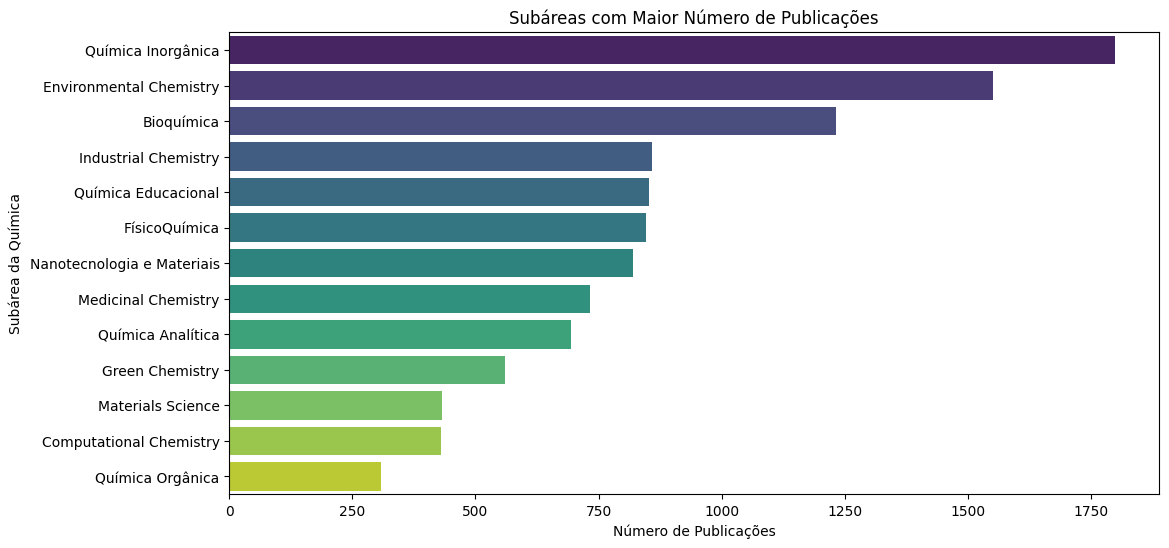

In [6]:
# 1. Quais subáreas da química têm maior número de publicações?
query1 = """
SELECT dp.subarea, COUNT(*) AS total_publicacoes
FROM Ponte_PalavraChave pp
JOIN Dim_PalavraChave dp ON pp.chavePalavraChave = dp.chavePalavraChave
GROUP BY dp.subarea
ORDER BY total_publicacoes DESC;
"""
df1 = executar_query(query1)

# Visualização
plt.figure(figsize=(12,6))
sns.barplot(y=df1['subarea'], x=df1['total_publicacoes'], palette='viridis')
plt.xlabel('Número de Publicações')
plt.ylabel('Subárea da Química')
plt.title('Subáreas com Maior Número de Publicações')
plt.show()

C:\Users\laura\AppData\Local\Temp\ipykernel_3356\2470173939.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


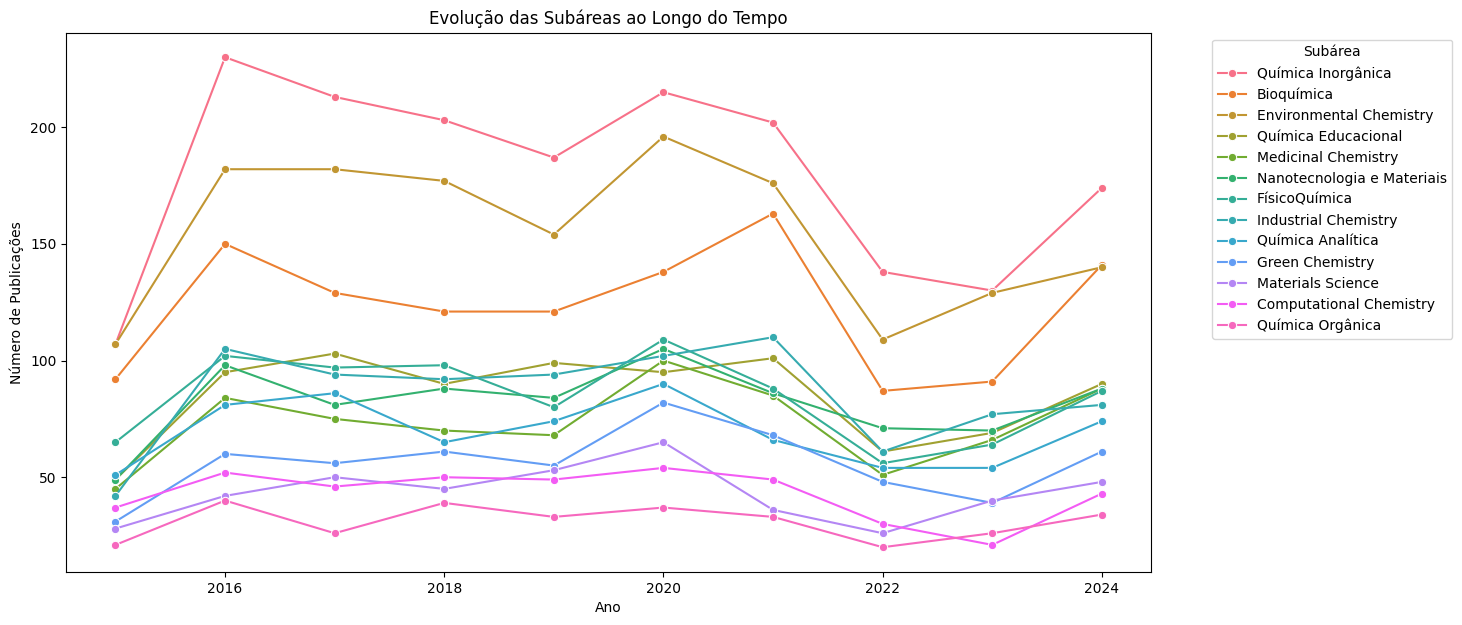

In [7]:
# 2. Como as subáreas mais populares mudaram nos últimos anos?
query2 = """
SELECT dt.ano, dp.subarea, COUNT(*) AS total_publicacoes
FROM Ponte_PalavraChave pp
JOIN Dim_PalavraChave dp ON pp.chavePalavraChave = dp.chavePalavraChave
JOIN Fato_Publicacao fp ON pp.chavePublicacao = fp.titulo
JOIN Dim_Tempo dt ON fp.chaveTempo = dt.chaveTempo
WHERE dt.ano >= EXTRACT(YEAR FROM CURRENT_DATE) - 10
GROUP BY dt.ano, dp.subarea
ORDER BY dt.ano DESC, total_publicacoes DESC;
"""
df2 = executar_query(query2)

# Visualização
plt.figure(figsize=(14,7))
sns.lineplot(data=df2, x='ano', y='total_publicacoes', hue='subarea', marker='o')
plt.xlabel('Ano')
plt.ylabel('Número de Publicações')
plt.title('Evolução das Subáreas ao Longo do Tempo')
plt.legend(title='Subárea', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

C:\Users\laura\AppData\Local\Temp\ipykernel_3356\2470173939.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)
C:\Users\laura\AppData\Local\Temp\ipykernel_3356\2702580336.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=df3['subarea'], x=df3['crescimento'], palette='coolwarm')


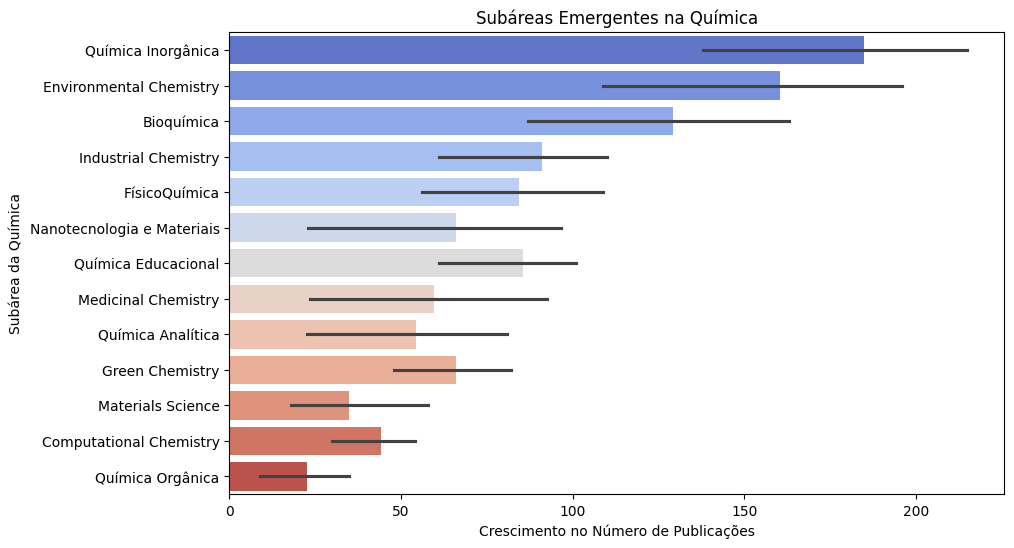

In [8]:
# 3. Subáreas emergentes
query3 = """
WITH publicacoes_recentes AS (
    SELECT dp.subarea, dt.ano, COUNT(*) AS total_publicacoes
    FROM Ponte_PalavraChave pp
    JOIN Dim_PalavraChave dp ON pp.chavePalavraChave = dp.chavePalavraChave
    JOIN Fato_Publicacao fp ON pp.chavePublicacao = fp.titulo
    JOIN Dim_Tempo dt ON fp.chaveTempo = dt.chaveTempo
    WHERE dt.ano >= EXTRACT(YEAR FROM CURRENT_DATE) - 5
    GROUP BY dp.subarea, dt.ano
)
SELECT pr1.subarea, 
       pr1.total_publicacoes AS publicacoes_atuais, 
       COALESCE(pr2.total_publicacoes, 0) AS publicacoes_passadas,
       (pr1.total_publicacoes - COALESCE(pr2.total_publicacoes, 0)) AS crescimento
FROM publicacoes_recentes pr1
LEFT JOIN publicacoes_recentes pr2
    ON pr1.subarea = pr2.subarea AND pr1.ano = pr2.ano + 3
WHERE (pr1.total_publicacoes - COALESCE(pr2.total_publicacoes, 0)) > 0
ORDER BY crescimento DESC;
"""
df3 = executar_query(query3)

# Visualização
plt.figure(figsize=(10,6))
sns.barplot(y=df3['subarea'], x=df3['crescimento'], palette='coolwarm')
plt.xlabel('Crescimento no Número de Publicações')
plt.ylabel('Subárea da Química')
plt.title('Subáreas Emergentes na Química')
plt.show()


C:\Users\laura\AppData\Local\Temp\ipykernel_3356\2470173939.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)
C:\Users\laura\AppData\Local\Temp\ipykernel_3356\1707712074.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=df4_top10['nome_instituicao'], x=df4_top10['total_publicacoes'], palette='magma')


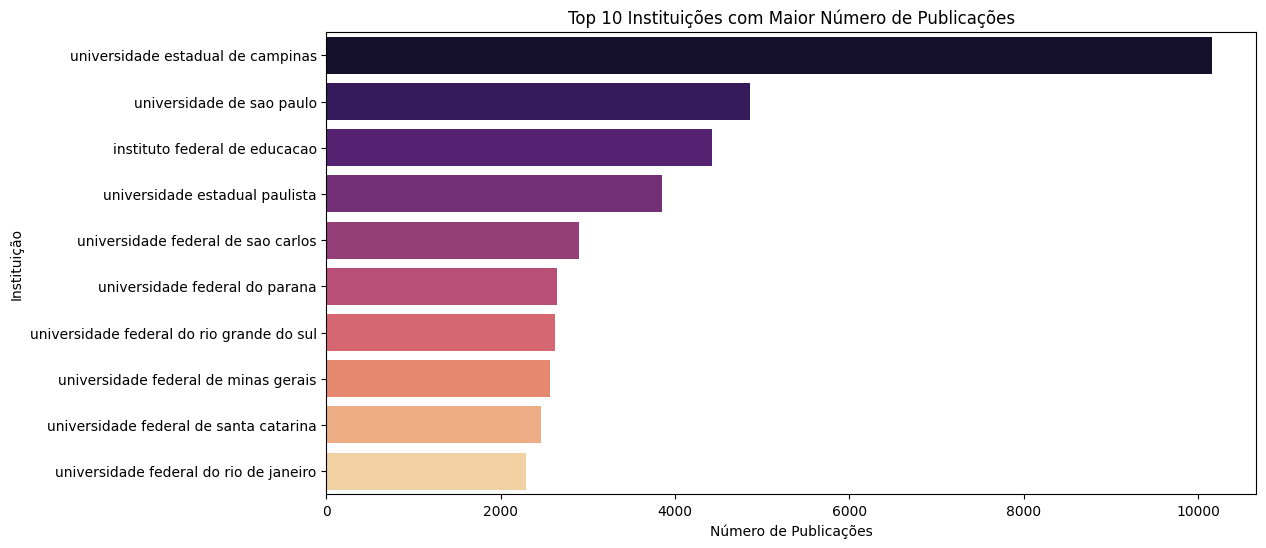

In [9]:
# 4. Quais instituições são responsáveis pelo maior número de publicações?
query4 = """
SELECT di.nome_instituicao, COUNT(*) AS total_publicacoes
FROM Ponte_Instituicao pi
JOIN Dim_Instituicao di ON pi.chaveInstituicao = di.chaveInstituicao
GROUP BY di.nome_instituicao
ORDER BY total_publicacoes DESC;
"""
df4 = executar_query(query4)

df4_top10 = df4.head(10)  # Selecionar apenas as 10 primeiras instituições

# Visualização
plt.figure(figsize=(12,6))
sns.barplot(y=df4_top10['nome_instituicao'], x=df4_top10['total_publicacoes'], palette='magma')
plt.xlabel('Número de Publicações')
plt.ylabel('Instituição')
plt.title('Top 10 Instituições com Maior Número de Publicações')
plt.show()

C:\Users\laura\AppData\Local\Temp\ipykernel_3356\2470173939.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


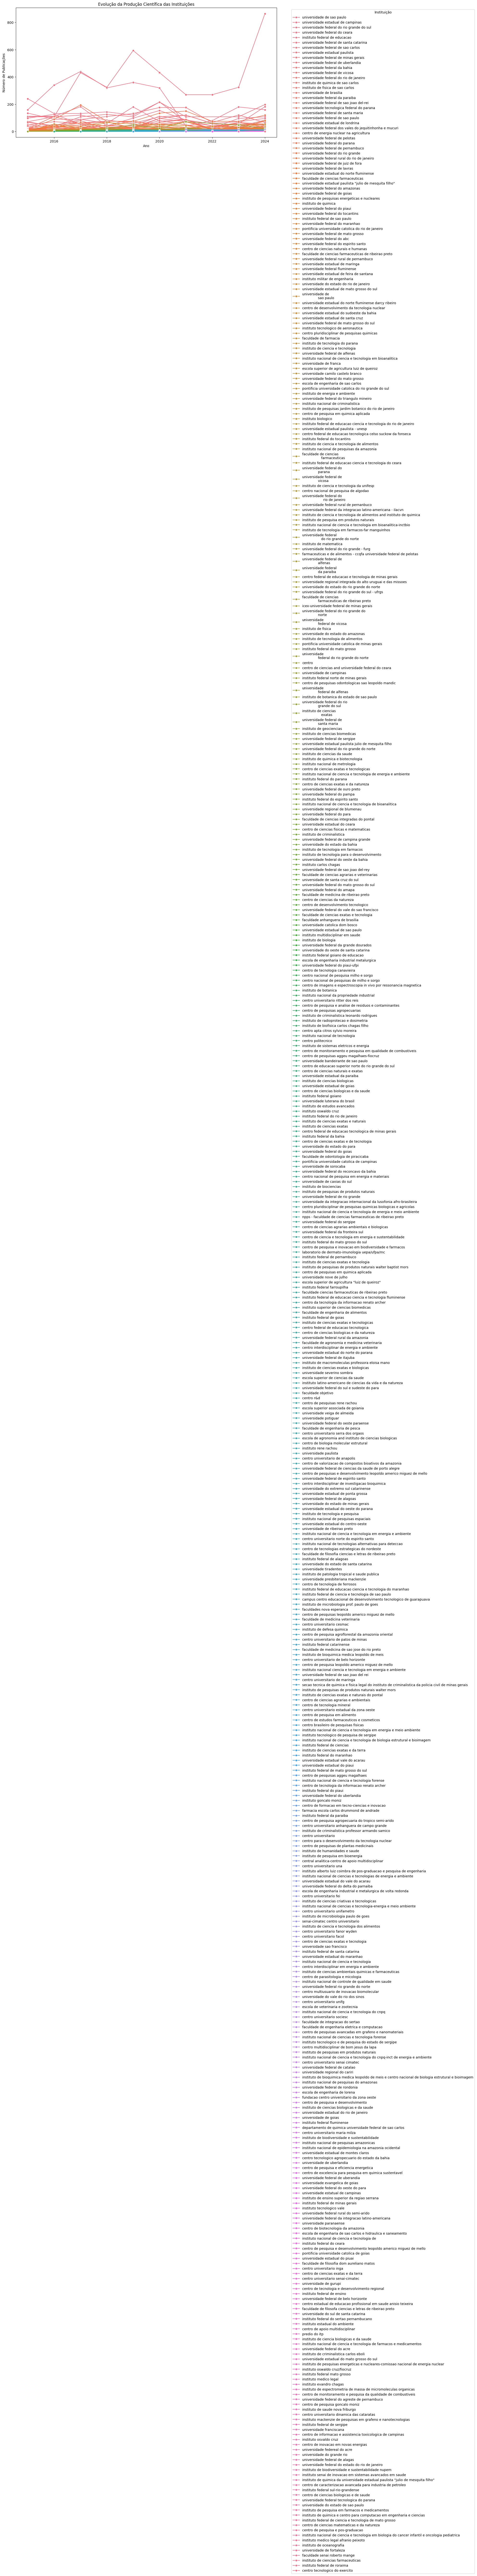

In [10]:
# 5. Como a produção científica das instituições evoluiu nos últimos anos?
query5 = """
SELECT dt.ano, di.nome_instituicao, COUNT(*) AS total_publicacoes
FROM Ponte_Instituicao pi
JOIN Dim_Instituicao di ON pi.chaveInstituicao = di.chaveInstituicao
JOIN Fato_Publicacao fp ON pi.chavePublicacao = fp.titulo
JOIN Dim_Tempo dt ON fp.chaveTempo = dt.chaveTempo
WHERE dt.ano >= EXTRACT(YEAR FROM CURRENT_DATE) - 10
GROUP BY dt.ano, di.nome_instituicao
ORDER BY dt.ano ASC, total_publicacoes DESC;
"""
df5 = executar_query(query5)

# Visualização
plt.figure(figsize=(14,7))
sns.lineplot(data=df5, x='ano', y='total_publicacoes', hue='nome_instituicao', marker='o')
plt.xlabel('Ano')
plt.ylabel('Número de Publicações')
plt.title('Evolução da Produção Científica das Instituições')
plt.legend(title='Instituição', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


C:\Users\laura\AppData\Local\Temp\ipykernel_3356\2470173939.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


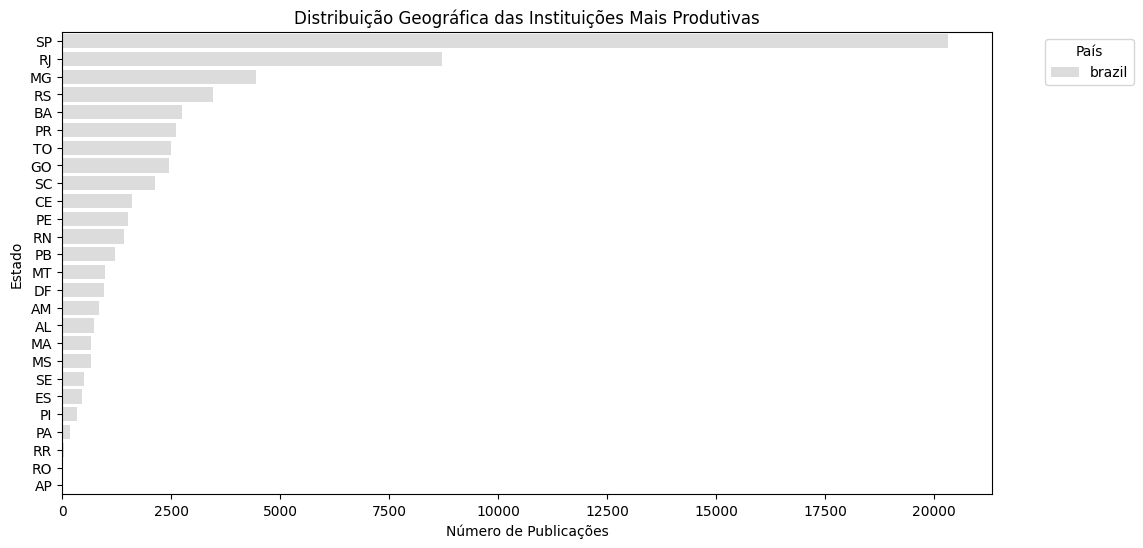

In [11]:
# 6. Distribuição geográfica das instituições mais produtivas
query6 = """
SELECT di.pais, di.regiao, di.estado, COUNT(*) AS total_publicacoes
FROM Ponte_Instituicao pi
JOIN Dim_Instituicao di ON pi.chaveInstituicao = di.chaveInstituicao
GROUP BY di.pais, di.regiao, di.estado
ORDER BY total_publicacoes DESC;
"""
df6 = executar_query(query6)

# Visualização
plt.figure(figsize=(12,6))
sns.barplot(y=df6['estado'], x=df6['total_publicacoes'], hue=df6['pais'], palette='coolwarm')
plt.xlabel('Número de Publicações')
plt.ylabel('Estado')
plt.title('Distribuição Geográfica das Instituições Mais Produtivas')
plt.legend(title='País', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

C:\Users\laura\AppData\Local\Temp\ipykernel_3356\2470173939.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


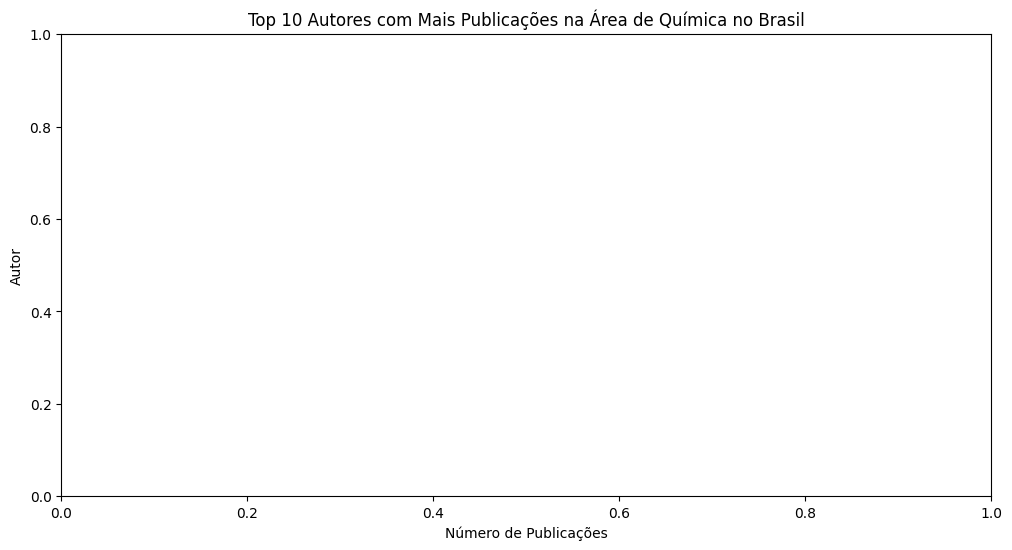

In [12]:
# 7. Autores que mais produziram na área de química no Brasil
query7 = """
SELECT da.nome_autor, COUNT(*) AS total_publicacoes
FROM Ponte_Autor pa
JOIN Dim_Autor da ON pa.chaveAutor = da.chaveAutor
JOIN Fato_Publicacao fp ON pa.chavePublicacao = fp.titulo
JOIN Ponte_Instituicao pi ON fp.titulo = pi.chavePublicacao
JOIN Dim_Instituicao di ON pi.chaveInstituicao = di.chaveInstituicao
WHERE di.pais = 'Brasil'
GROUP BY da.nome_autor
ORDER BY total_publicacoes DESC
LIMIT 10;
"""
df7 = executar_query(query7)

# Visualização
plt.figure(figsize=(12,6))
sns.barplot(y=df7['nome_autor'], x=df7['total_publicacoes'], palette='plasma')
plt.xlabel('Número de Publicações')
plt.ylabel('Autor')
plt.title('Top 10 Autores com Mais Publicações na Área de Química no Brasil')
plt.show()

C:\Users\laura\AppData\Local\Temp\ipykernel_3356\2470173939.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


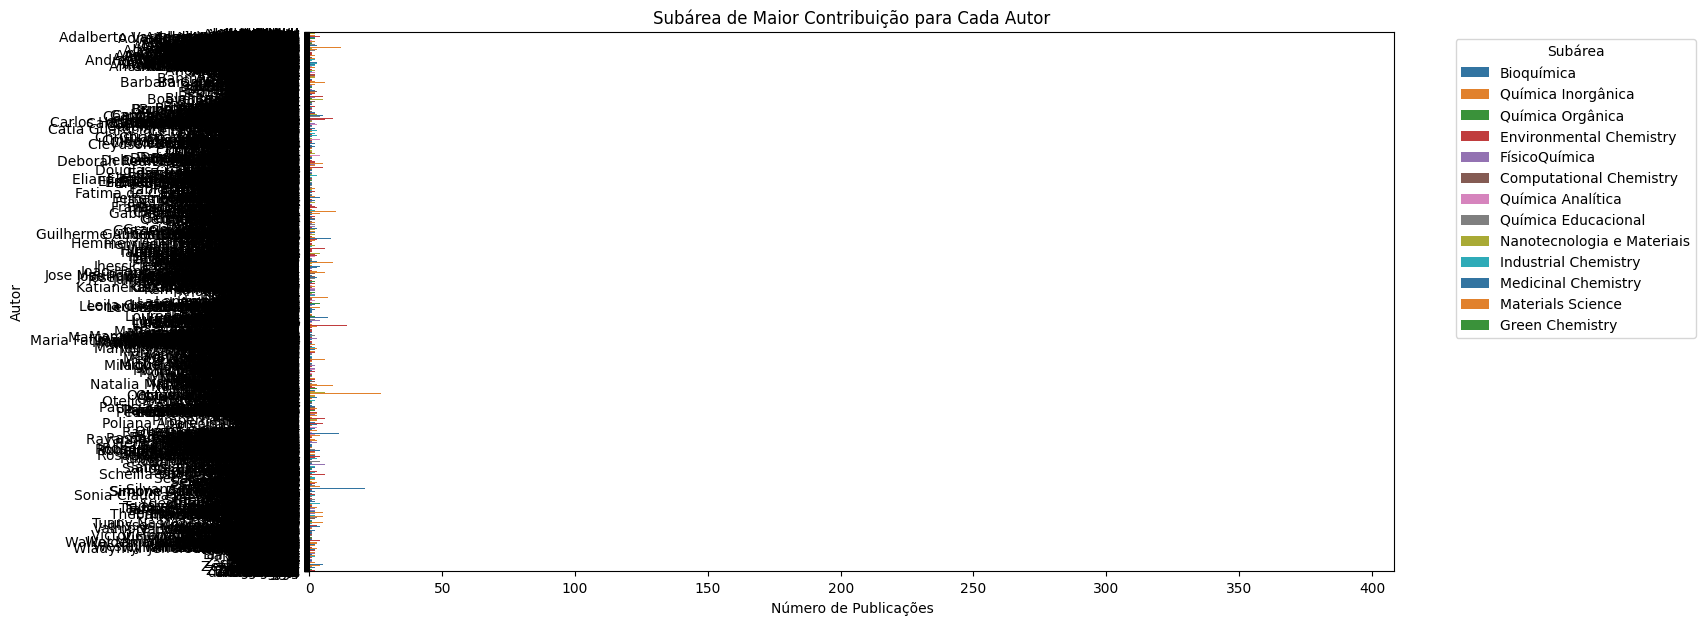

In [13]:
# 8. Em quais subáreas cada autor tem maior contribuição?
query8 = """
SELECT da.nome_autor, dp.subarea, COUNT(*) AS total_publicacoes
FROM Ponte_Autor pa
JOIN Dim_Autor da ON pa.chaveAutor = da.chaveAutor
JOIN Fato_Publicacao fp ON pa.chavePublicacao = fp.titulo
JOIN Ponte_PalavraChave pp ON fp.titulo = pp.chavePublicacao
JOIN Dim_PalavraChave dp ON pp.chavePalavraChave = dp.chavePalavraChave
GROUP BY da.nome_autor, dp.subarea
ORDER BY da.nome_autor, total_publicacoes DESC;
"""
df8 = executar_query(query8)

# Selecionar a subárea mais relevante para cada autor
df8_max = df8.loc[df8.groupby('nome_autor')['total_publicacoes'].idxmax()]

# Visualização
plt.figure(figsize=(14,7))
sns.barplot(y=df8_max['nome_autor'], x=df8_max['total_publicacoes'], hue=df8_max['subarea'], dodge=False, palette='tab10')
plt.xlabel('Número de Publicações')
plt.ylabel('Autor')
plt.title('Subárea de Maior Contribuição para Cada Autor')
plt.legend(title='Subárea', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

C:\Users\laura\AppData\Local\Temp\ipykernel_3356\2470173939.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


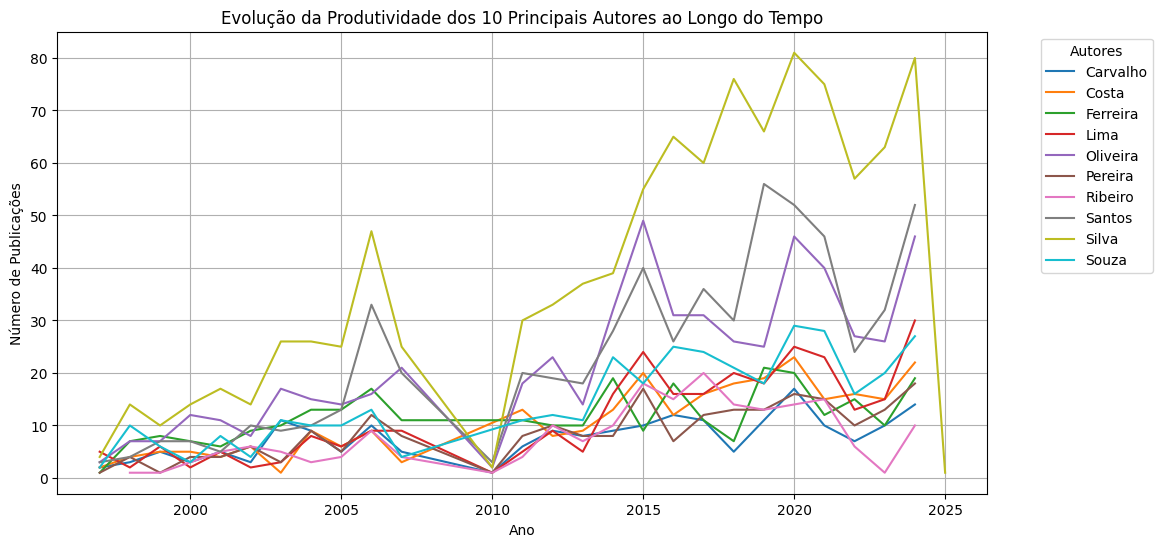

In [14]:
# 9. Como a produtividade dos autores principais mudou ao longo dos anos?
query9 = """
WITH PublicacoesPorAutor AS (
    SELECT 
        a.nome_autor,
        t.ano,
        COUNT(f.titulo) AS numero_publicacoes
    FROM 
        Ponte_Autor pa
    JOIN 
        Dim_Autor a ON pa.chaveAutor = a.chaveAutor
    JOIN 
        Fato_Publicacao f ON pa.chavePublicacao = f.titulo
    JOIN 
        Dim_Tempo t ON f.chaveTempo = t.chaveTempo
    GROUP BY 
        a.nome_autor, t.ano
)
SELECT 
    nome_autor,
    ano,
    numero_publicacoes
FROM 
    PublicacoesPorAutor
WHERE 
    nome_autor IN (
        SELECT nome_autor
        FROM PublicacoesPorAutor
        GROUP BY nome_autor
        ORDER BY SUM(numero_publicacoes) DESC
        LIMIT 10
    )
ORDER BY 
    nome_autor, ano;
"""

# Executar a consulta
df9 = executar_query(query9)

# Visualização
plt.figure(figsize=(12, 6))

# Plotando a evolução da produtividade dos principais autores
for autor in df9['nome_autor'].unique():
    autor_data = df9[df9['nome_autor'] == autor]
    plt.plot(autor_data['ano'], autor_data['numero_publicacoes'], label=autor)

plt.title("Evolução da Produtividade dos 10 Principais Autores ao Longo do Tempo")
plt.xlabel("Ano")
plt.ylabel("Número de Publicações")
plt.legend(title='Autores', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

C:\Users\laura\AppData\Local\Temp\ipykernel_3356\2470173939.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


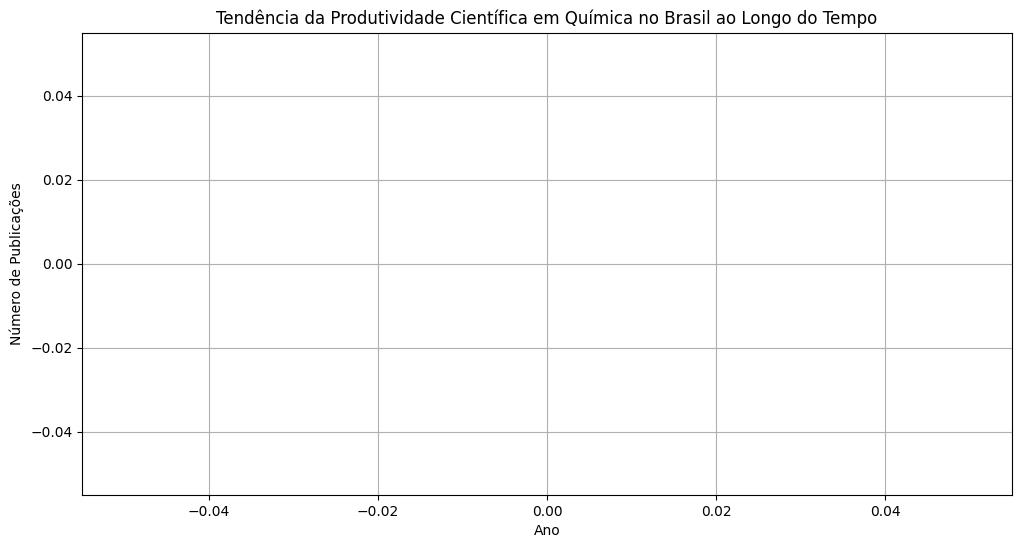

In [16]:
# Consulta SQL
query10 = """
SELECT 
    t.ano,
    COUNT(f.titulo) AS numero_publicacoes
FROM 
    Ponte_PalavraChave pp
JOIN 
    Dim_PalavraChave p ON pp.chavePalavraChave = p.chavePalavraChave
JOIN 
    Fato_Publicacao f ON pp.chavePublicacao = f.titulo
JOIN 
    Dim_Tempo t ON f.chaveTempo = t.chaveTempo
JOIN 
    Ponte_Instituicao pi ON f.titulo = pi.chavePublicacao
JOIN 
    Dim_Instituicao di ON pi.chaveInstituicao = di.chaveInstituicao
WHERE 
    p.palavraChave LIKE '%química%'  -- Filtrando publicações relacionadas à química
    AND di.pais = 'Brasil'           -- Filtrando para instituições no Brasil
GROUP BY 
    t.ano
ORDER BY 
    t.ano;
"""

# Executar a consulta
df10 = executar_query(query10)

# Visualização
plt.figure(figsize=(12, 6))

sns.lineplot(data=df10, x='ano', y='numero_publicacoes', marker='o')
plt.title('Tendência da Produtividade Científica em Química no Brasil ao Longo do Tempo')
plt.xlabel('Ano')
plt.ylabel('Número de Publicações')
plt.grid(True)
plt.show()



C:\Users\laura\AppData\Local\Temp\ipykernel_3356\2470173939.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


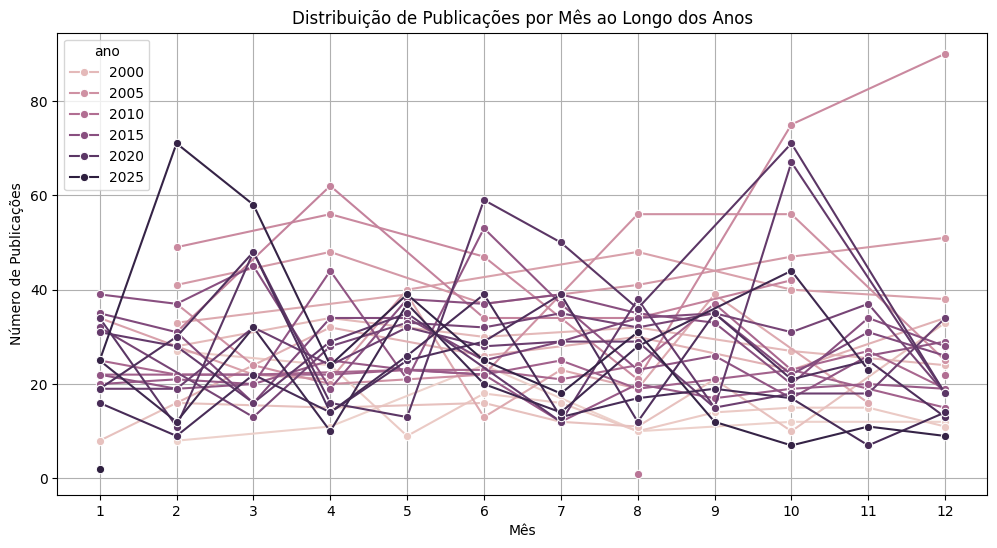

In [17]:
# Consulta SQL para identificar meses com maior número de publicações
query11 = """
SELECT 
    t.ano,
    t.mes,
    COUNT(f.titulo) AS numero_publicacoes
FROM 
    Fato_Publicacao f
JOIN 
    Dim_Tempo t ON f.chaveTempo = t.chaveTempo
GROUP BY 
    t.ano, t.mes
ORDER BY 
    t.ano, t.mes;
"""

# Executar a consulta
df11 = executar_query(query11)
# Visualização
plt.figure(figsize=(12, 6))

# Plotando a distribuição de publicações por mês
sns.lineplot(data=df11, x='mes', y='numero_publicacoes', hue='ano', marker='o')
plt.title('Distribuição de Publicações por Mês ao Longo dos Anos')
plt.xlabel('Mês')
plt.ylabel('Número de Publicações')
plt.xticks(range(1, 13))  # Definindo os meses de 1 a 12
plt.grid(True)
plt.show()


C:\Users\laura\AppData\Local\Temp\ipykernel_3356\2470173939.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


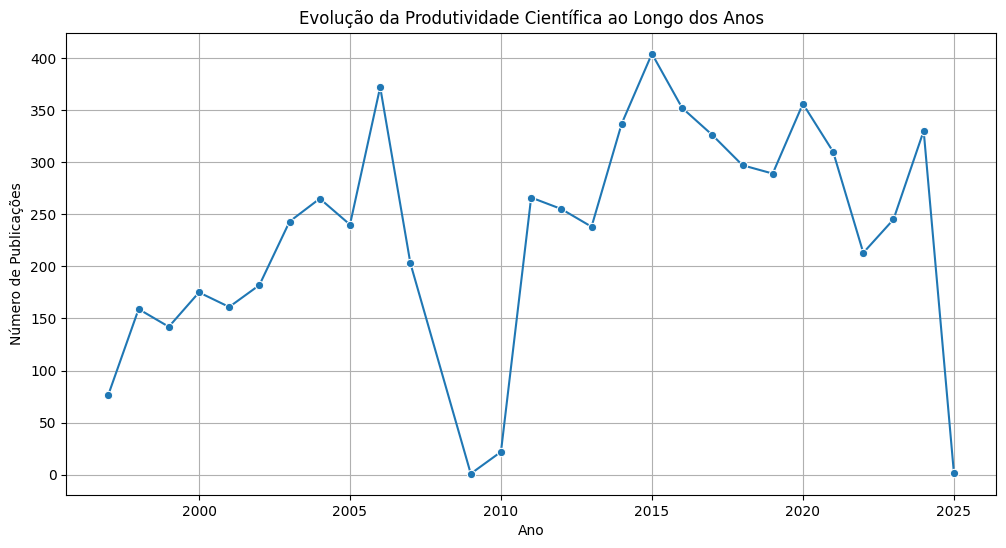

In [18]:
# Consulta SQL
query12 = """
SELECT 
    t.ano,
    COUNT(f.titulo) AS numero_publicacoes
FROM 
    Fato_Publicacao f
JOIN 
    Dim_Tempo t ON f.chaveTempo = t.chaveTempo
GROUP BY 
    t.ano
ORDER BY 
    t.ano;
"""

# Executar a consulta
df12 = executar_query(query12)
# Visualização
plt.figure(figsize=(12, 6))

# Plotando a produtividade científica ao longo dos anos
sns.lineplot(data=df12, x='ano', y='numero_publicacoes', marker='o')
plt.title('Evolução da Produtividade Científica ao Longo dos Anos')
plt.xlabel('Ano')
plt.ylabel('Número de Publicações')
plt.grid(True)
plt.show()


C:\Users\laura\AppData\Local\Temp\ipykernel_3356\2470173939.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


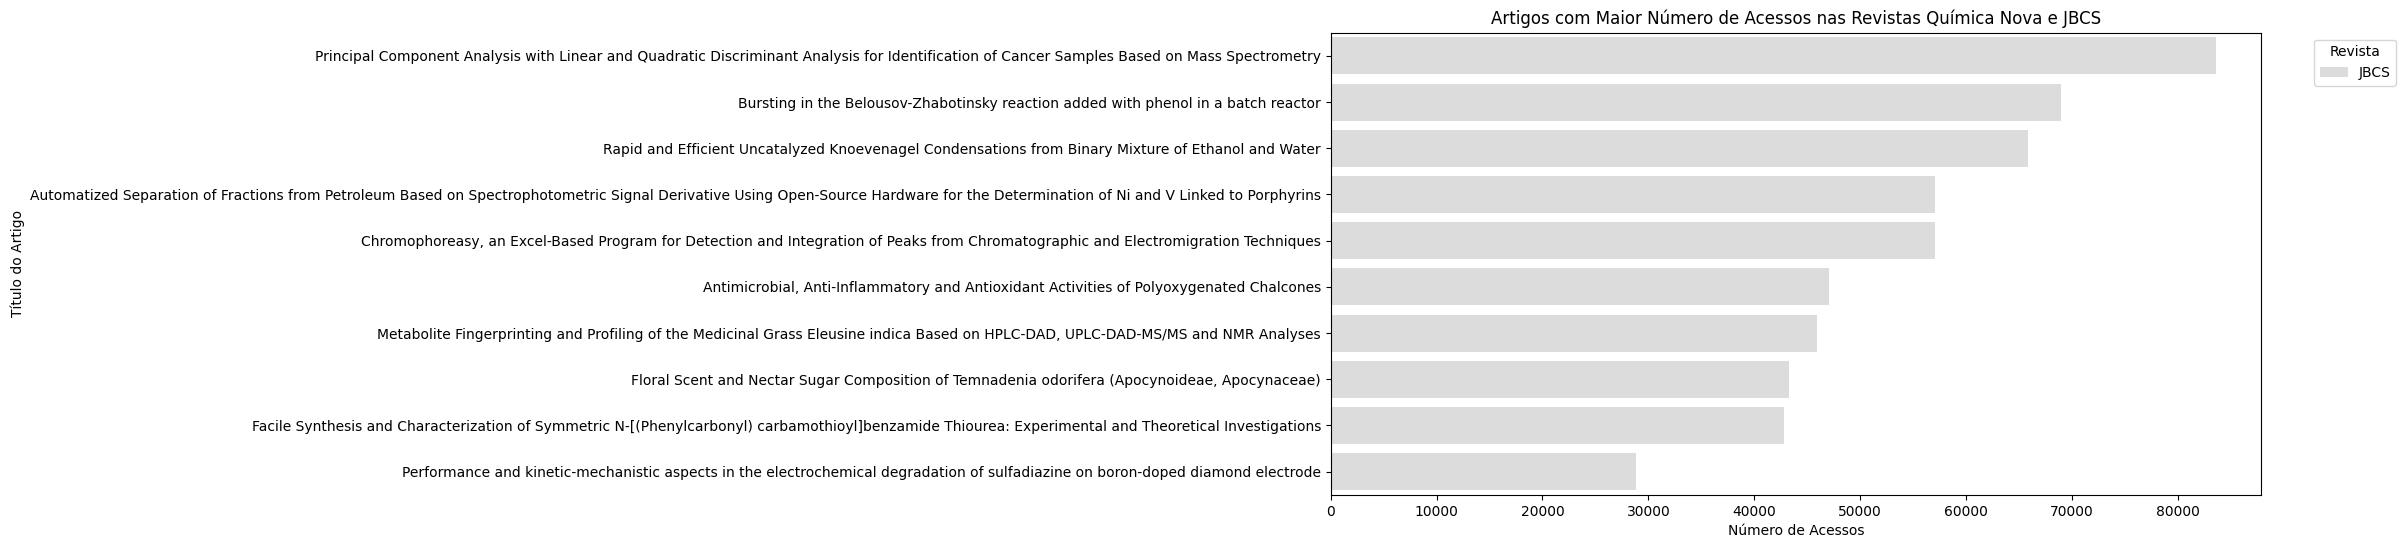

In [19]:
# Consulta SQL
query13 = """
SELECT 
    f.titulo,
    f.numero_acessos,
    f.nome_revista
FROM 
    Fato_Publicacao f
WHERE 
    f.nome_revista IN ('Química Nova', 'JBCS')
ORDER BY 
    f.numero_acessos DESC
LIMIT 10;
"""

# Executar a consulta
df13 = executar_query(query13)
# Visualização
plt.figure(figsize=(12, 6))

# Plotando os artigos com maior número de acessos
sns.barplot(data=df13, x='numero_acessos', y='titulo', hue='nome_revista', palette='coolwarm')
plt.title('Artigos com Maior Número de Acessos nas Revistas Química Nova e JBCS')
plt.xlabel('Número de Acessos')
plt.ylabel('Título do Artigo')
plt.legend(title='Revista', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


C:\Users\laura\AppData\Local\Temp\ipykernel_3356\2470173939.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)
C:\Users\laura\AppData\Local\Temp\ipykernel_3356\1801529468.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_instituicoes, x='numero_acessos', y='nome_instituicao', palette='coolwarm')


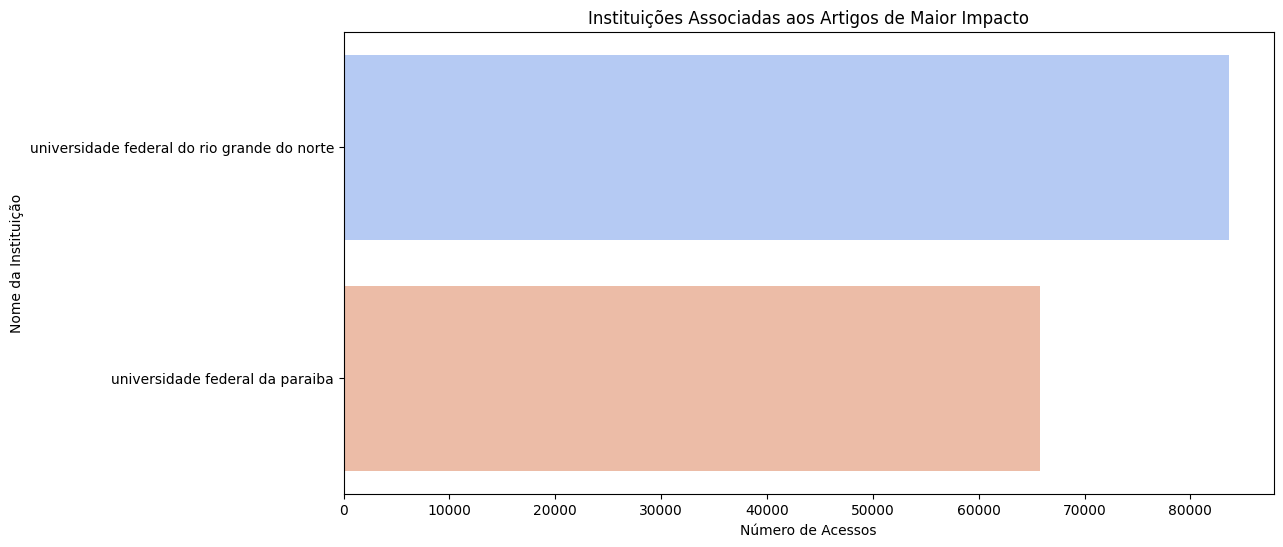

In [20]:
# Consulta SQL para autores (sem o LIMIT)
query14_autores = """
SELECT 
    f.titulo,
    f.numero_acessos,
    da.nome_autor
FROM 
    Fato_Publicacao f
JOIN 
    Ponte_Autor pa ON f.titulo = pa.chavePublicacao
JOIN 
    Dim_Autor da ON pa.chaveAutor = da.chaveAutor
ORDER BY 
    f.numero_acessos DESC;
"""

# Executar a consulta para autores
df14_autores = executar_query(query14_autores)

# Consulta SQL para instituições (sem o LIMIT)
query14_instituicoes = """
SELECT 
    f.titulo,
    f.numero_acessos,
    di.nome_instituicao
FROM 
    Fato_Publicacao f
JOIN 
    Ponte_Instituicao pi ON f.titulo = pi.chavePublicacao
JOIN 
    Dim_Instituicao di ON pi.chaveInstituicao = di.chaveInstituicao
ORDER BY 
    f.numero_acessos DESC;
"""

# Executar a consulta para instituições
df14_instituicoes = executar_query(query14_instituicoes)
# Visualização para instituições (limitando a 10 no gráfico)
plt.figure(figsize=(12, 6))

# Selecionando as top 10 instituições com mais acessos
top_instituicoes = df14_instituicoes.head(10)

# Plotando as instituições com maior número de acessos
sns.barplot(data=top_instituicoes, x='numero_acessos', y='nome_instituicao', palette='coolwarm')
plt.title('Instituições Associadas aos Artigos de Maior Impacto')
plt.xlabel('Número de Acessos')
plt.ylabel('Nome da Instituição')
plt.show()


C:\Users\laura\AppData\Local\Temp\ipykernel_3356\2470173939.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)
C:\Users\laura\AppData\Local\Temp\ipykernel_3356\2069190512.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df15_media_subarea, x='numero_acessos', y='subarea', palette='coolwarm')


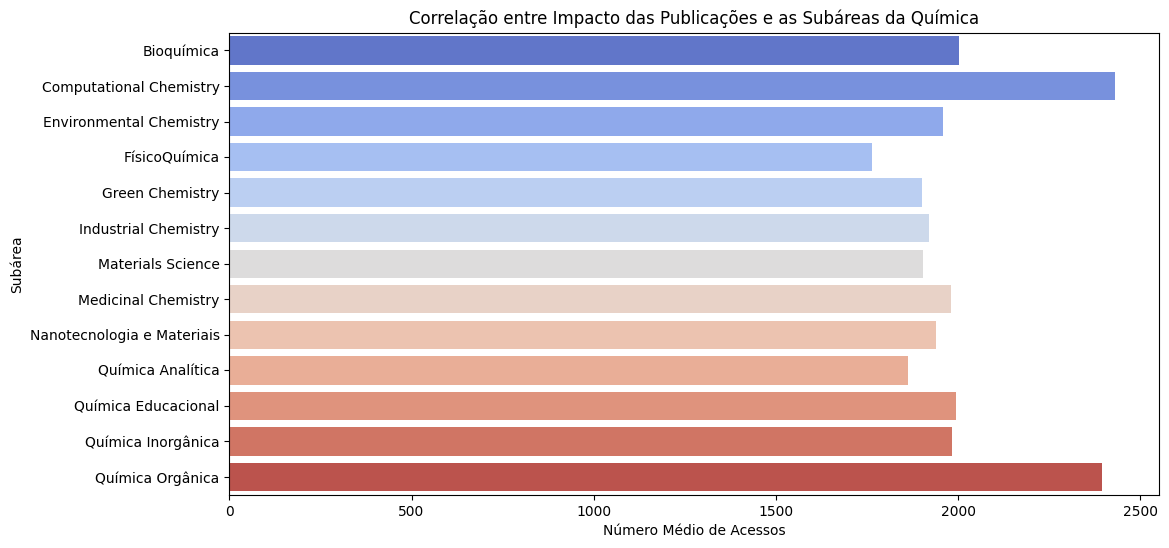

In [21]:
# Consulta SQL para correlacionar o impacto das publicações (número de acessos) com as subáreas
query15 = """
SELECT 
    dp.palavraChave,
    dp.subarea,
    f.numero_acessos
FROM 
    Fato_Publicacao f
JOIN 
    Ponte_PalavraChave pp ON f.titulo = pp.chavePublicacao
JOIN 
    Dim_PalavraChave dp ON pp.chavePalavraChave = dp.chavePalavraChave
ORDER BY 
    f.numero_acessos DESC;
"""

# Executar a consulta
df15 = executar_query(query15)
# Calculando a média de acessos por subárea
df15_media_subarea = df15.groupby('subarea')['numero_acessos'].mean().reset_index()

# Visualização
plt.figure(figsize=(12, 6))

# Plotando a correlação entre impacto e subáreas
sns.barplot(data=df15_media_subarea, x='numero_acessos', y='subarea', palette='coolwarm')
plt.title('Correlação entre Impacto das Publicações e as Subáreas da Química')
plt.xlabel('Número Médio de Acessos')
plt.ylabel('Subárea')
plt.show()


C:\Users\laura\AppData\Local\Temp\ipykernel_3356\2470173939.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)
C:\Users\laura\AppData\Local\Temp\ipykernel_3356\3521214538.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Região', bbox_to_anchor=(1.05, 1), loc='upper left')


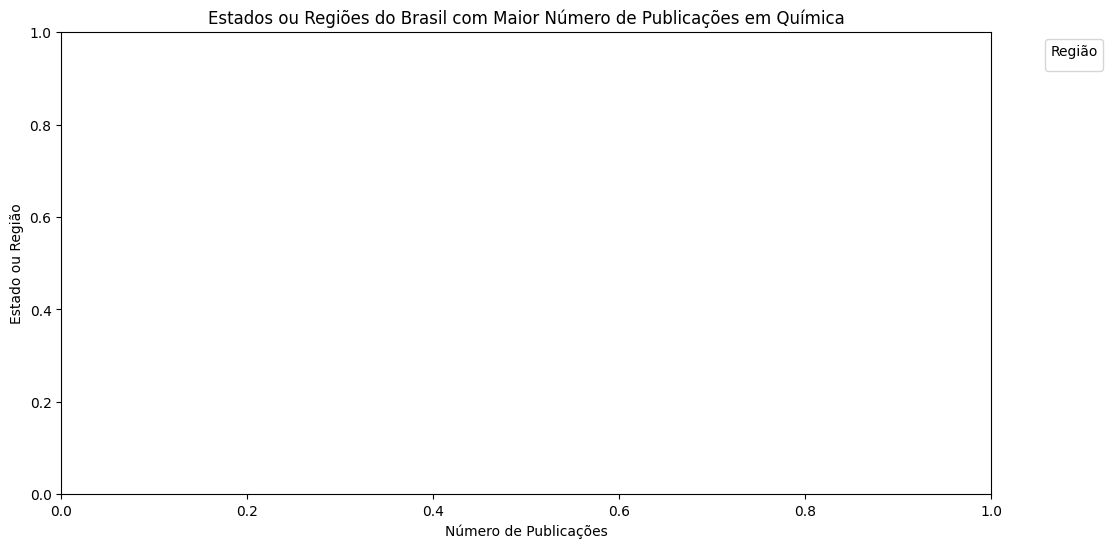

In [22]:
# Consulta SQL para estados ou regiões com maior número de publicações em química
query16 = """
SELECT 
    di.regiao,
    di.estado,
    COUNT(f.titulo) AS numero_publicacoes
FROM 
    Fato_Publicacao f
JOIN 
    Ponte_Instituicao pi ON f.titulo = pi.chavePublicacao
JOIN 
    Dim_Instituicao di ON pi.chaveInstituicao = di.chaveInstituicao
WHERE 
    di.pais = 'Brasil'
GROUP BY 
    di.regiao, di.estado
ORDER BY 
    numero_publicacoes DESC;
"""

# Executar a consulta
df16 = executar_query(query16)
# Visualização
plt.figure(figsize=(12, 6))

# Plotando os estados ou regiões com maior número de publicações
sns.barplot(data=df16, x='numero_publicacoes', y='estado', hue='regiao', palette='coolwarm')
plt.title('Estados ou Regiões do Brasil com Maior Número de Publicações em Química')
plt.xlabel('Número de Publicações')
plt.ylabel('Estado ou Região')
plt.legend(title='Região', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


C:\Users\laura\AppData\Local\Temp\ipykernel_3356\2470173939.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


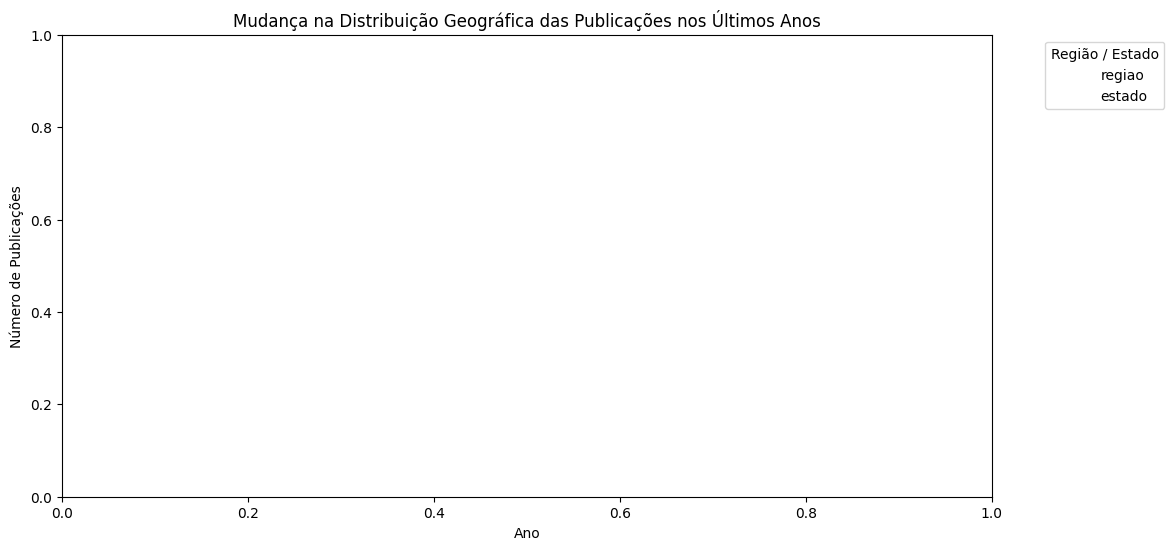

In [23]:
# Consulta SQL para a mudança na distribuição geográfica das publicações ao longo dos anos
query17 = """
SELECT 
    t.ano,
    di.regiao,
    di.estado,
    COUNT(f.titulo) AS numero_publicacoes
FROM 
    Fato_Publicacao f
JOIN 
    Dim_Tempo t ON f.chaveTempo = t.chaveTempo
JOIN 
    Ponte_Instituicao pi ON f.titulo = pi.chavePublicacao
JOIN 
    Dim_Instituicao di ON pi.chaveInstituicao = di.chaveInstituicao
WHERE 
    di.pais = 'Brasil'
GROUP BY 
    t.ano, di.regiao, di.estado
ORDER BY 
    t.ano, numero_publicacoes DESC;
"""

# Executar a consulta
df17 = executar_query(query17)
# Visualização
plt.figure(figsize=(12, 6))

# Plotando a mudança na distribuição geográfica ao longo dos anos
sns.lineplot(data=df17, x='ano', y='numero_publicacoes', hue='regiao', style='estado', markers=True)
plt.title('Mudança na Distribuição Geográfica das Publicações nos Últimos Anos')
plt.xlabel('Ano')
plt.ylabel('Número de Publicações')
plt.legend(title='Região / Estado', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


C:\Users\laura\AppData\Local\Temp\ipykernel_3356\2470173939.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)
C:\Users\laura\AppData\Local\Temp\ipykernel_3356\3754898731.py:36: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df18_anos_pivot, palette='coolwarm', markers=True)
C:\Users\laura\AppData\Local\Temp\ipykernel_3356\3754898731.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Região', bbox_to_anchor=(1.05, 1), loc='upper left')


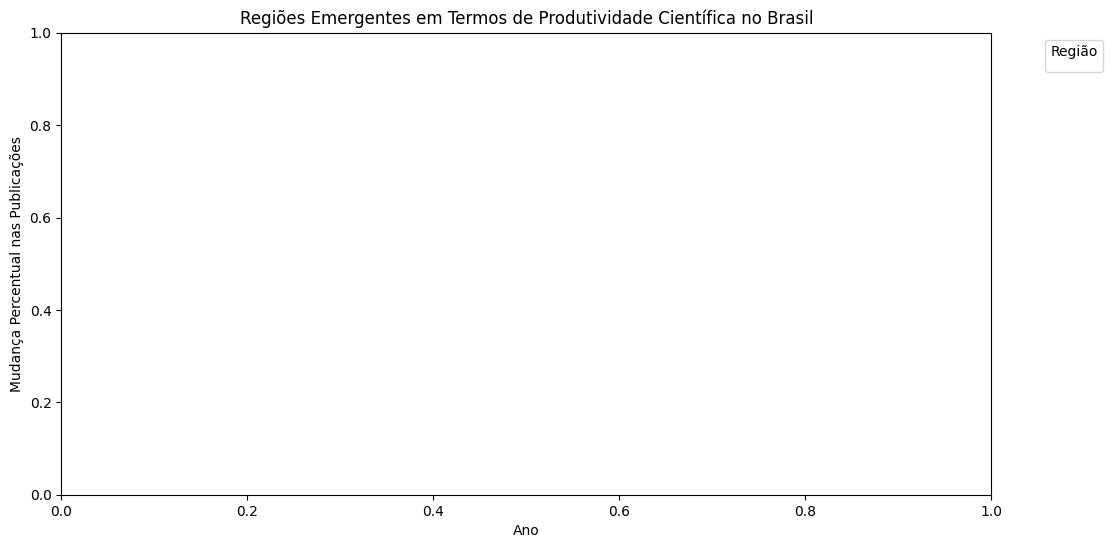

In [24]:
# Consulta SQL para identificar regiões emergentes com base no aumento de publicações ao longo dos anos
query18 = """
SELECT 
    t.ano,
    di.regiao,
    COUNT(f.titulo) AS numero_publicacoes
FROM 
    Fato_Publicacao f
JOIN 
    Dim_Tempo t ON f.chaveTempo = t.chaveTempo
JOIN 
    Ponte_Instituicao pi ON f.titulo = pi.chavePublicacao
JOIN 
    Dim_Instituicao di ON pi.chaveInstituicao = di.chaveInstituicao
WHERE 
    di.pais = 'Brasil'
GROUP BY 
    t.ano, di.regiao
ORDER BY 
    t.ano, numero_publicacoes DESC;
"""

# Executar a consulta
df18 = executar_query(query18)
# Calculando a diferença no número de publicações por região entre o primeiro e o último ano
df18_anos = df18.groupby(['ano', 'regiao'])['numero_publicacoes'].sum().reset_index()
df18_anos_pivot = df18_anos.pivot(index='ano', columns='regiao', values='numero_publicacoes')

# Calculando a mudança percentual nas publicações de cada região
df18_anos_pivot = df18_anos_pivot.pct_change(axis='index') * 100

# Visualização
plt.figure(figsize=(12, 6))

# Plotando a mudança percentual de publicações ao longo do tempo
sns.lineplot(data=df18_anos_pivot, palette='coolwarm', markers=True)
plt.title('Regiões Emergentes em Termos de Produtividade Científica no Brasil')
plt.xlabel('Ano')
plt.ylabel('Mudança Percentual nas Publicações')
plt.legend(title='Região', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
